# Assignment 3 - Sparse Matrices
## Part 1: Implementing a CSR matrix
Scipy allows you to define your own objects that can be used with their sparse solvers. You can do this by creating a subclass of scipy.sparse LinearOperator. In the first part of this assignment, you are going to implement your own CSR matrix format.

In [1]:
import numpy as np
import scipy
from scipy import sparse
from scipy.sparse.linalg import LinearOperator
import numba
from numba import njit
from scipy.sparse import coo_matrix,csr_matrix, linalg
from timeit import timeit
import matplotlib.pyplot as plt
from tqdm import tqdm

In [44]:
@njit
def jit_matvec(data, indices, indptr, vector, rows):
    '''
    Compute the matrix vector multiplication for a CSR matrix 

    Inputs
    - data - non-zero elements in the CSR matrix
    - indices - column indices corresponding to data
    - indptr - index pointers
    - vector - dense vector to multiply matrix with
    - rows - number of rows in the CSR matrix

    Outputs
    - output - output vector from the calculation
    '''

    # Initialise the output vector
    output = np.zeros(rows, dtype=data.dtype)

    # Iterate over each row of the sparse matrix
    for row in range(rows):
        col_start = indptr[row]    
        col_end = indptr[row + 1]

        # Iterate over non-zero elements
        for col_ind in range(col_start, col_end):
            # Multiply matrix value with the corresponding vector value
            output[row] += (data[col_ind] * vector[indices[col_ind]])
    return output

class CSRMatrix(LinearOperator):
    def __init__(self, coo_matrix):

        self.shape = coo_matrix.shape
        self.dtype = coo_matrix.dtype
        '''
        COO:
        Row indices
        Column indices
        Data entries

        CSR:
        Data entries
        Column indices
        Index pointers
        
        Initialise a CSRMatrix object from a COO matrix.

        Inputs
        - coo_matrix - input matrix in COO format
        '''

        # Extracting the COO matrix data
        coorowind = coo_matrix.row
        coocolind = coo_matrix.col
        coodata = coo_matrix.data
        
        # Sort first by row, then by column
        order = np.lexsort((coocolind, coorowind))
        csrcolind = coocolind[order]
        csrdata = coodata[order]
        
        # Initialise index pointers
        indptr = [0]
        counter = 0
        
        # Generate index pointers
        for i in range(0,self.shape[0]-1):
            counter += np.count_nonzero(coorowind == i)
            indptr.append(counter)
        
        indptr.append(len(coorowind))

        test = csr_matrix((csrdata, csrcolind, indptr))

        # Make sure CSRMatrix generates CSR matrices correctly
        assert np.allclose(coo_matrix.toarray(), test.toarray())
        
        self.data = csrdata
        self.indices = csrcolind
        self.indptr = indptr


    def __add__(self, other):
        '''
        Adds self CSR matrix to other CSR matrix and returns a results as a CSR matrix.
        Converts each all data points into coordinate-like COO points and adds each point

        Inputs
        - self - input CSR matrix
        - other - another CSR matrix

        Outputs
        - results_csr - data, indices, indptr. Information needed for CSR matrix
        '''

        # Check the same shape
        assert self.shape == other.shape

        row, col = self.shape

        # Extracting csr matrix data from self matrix
        A_data = self.data
        A_indices = self.indices
        A_indptr = self.indptr

        # Extracting csr matrix data from other matrix
        B_data = other.data
        B_indices = other.indices
        B_indptr = other.indptr

        # Set up results matrix
        result_dict = {}

        # Process matrix A
        for row in range(len(A_indptr) - 1):
            for index in range(A_indptr[row], A_indptr[row + 1]):
                col = A_indices[index]
                value = A_data[index]
                if (row, col) in result_dict:
                    result_dict[(row, col)] += value
                else:
                    result_dict[(row, col)] = value

        # Process matrix B
        for row in range(len(B_indptr) - 1):
            for index in range(B_indptr[row], B_indptr[row + 1]):
                col = B_indices[index]
                value = B_data[index]
                if (row, col) in result_dict:
                    result_dict[(row, col)] += value
                else:
                    result_dict[(row, col)] = value

        # Convert result_dict to CSR format
        # * opens up the (row, col, value)
        # zip tranposes the row, col, value to the right places
        rows, cols, data = zip(*((row, col, value) for (row, col), value in result_dict.items()))

        rows = np.array(rows)
        cols = np.array(cols)
        data = np.array(data)

        results_coo = coo_matrix((data, (rows, cols)), shape=(self.shape))

        # Create the result CSR matrix
        results_csr = CSRMatrix(results_coo)

        return results_csr
    
    def _matvec(self, vector):
        '''
        Compute a matrix-vector product.

        Inputs
        - self - input CSR matrix
        - vector - input 1D vector

        Outputs
        - output - the resultant vector
        '''
        
        assert self.shape[1] == vector.shape[0]
        vecshape = self.shape[1]

        # Call JIT-compiled function
        output = jit_matvec(np.array(self.data), np.array(self.indices), np.array(self.indptr), vector, vecshape)

        return output

## Testing CSR conversion
Here we check that we get the correct CSR matrix outputs for `CSRMatrix` given some COO matrix by comparing against the built-in `scipy` implentation in python.

In [45]:
testrange = np.arange(100,1000,100)

for i in testrange:
    A = scipy.sparse.random(i, i, density=0.5, format='coo')

    # Using built-in csr conversion function
    A_csr = csr_matrix(A)

    # Using my CSR class converter
    A_csr_class = CSRMatrix(A)

    assert np.allclose(A_csr.toarray(), csr_matrix((A_csr_class.data, A_csr_class.indices, A_csr_class.indptr)).toarray())
print('Class conversion works!')

Class conversion works!


## Testing CSR addition
Here we check that we get the correct matrix outputs for `CSRMatrix` for adding two sparse matrices by comparing the result against the addition of the same matrix in the COO format.

In [46]:
testrange = np.arange(100,1000,100)

for i in testrange:
    A = scipy.sparse.random(i, i, density=0.5, format='coo')
    B = scipy.sparse.random(i, i, density=0.5, format='coo')

    A_coo = coo_matrix(A)
    B_coo = coo_matrix(B)

    A_csr = CSRMatrix(A)
    B_csr = CSRMatrix(B)

    C_coo = A_coo + B_coo
    C_csr  = A_csr + B_csr
    
    assert np.allclose(C_coo.toarray(), csr_matrix((C_csr.data, C_csr.indices, C_csr.indptr)).toarray())

print('Addition works!')

Addition works!


## Testing `matvec`
For `matvec` we iterate through each row and multiply the entries in that row by the corresponding entry in the vector. In the function here, the relevant information is parsed to a `jit` compiled function that carries out the calculation. Originally it was carried out in the `matvec` function and was very slow due to the nested for loops and no `numba` acceleration ($50 s$ vs $6 s$)

In [47]:
testrange = np.arange(100,1000,100)

for i in testrange:
    A = scipy.sparse.random(i, i, density=0.5, format='coo')
    Bvec = np.random.rand(i)

    A_coo = coo_matrix(A)

    A_csr = CSRMatrix(A)

    C_coo = A_coo @ Bvec
    C_csr  = A_csr @ Bvec
    
    assert np.allclose(C_coo, C_csr)
print("matvec works")

matvec works


## Timing matvec

In [ ]:
testrange = np.arange(2, 5001,100)

matvec_times = []
numpy_times = []

for i in tqdm(testrange):

    # Create matrices
    mat = scipy.sparse.random(i, i, density=0.5, format='coo')
    vec = np.random.rand(i)

    # Convert to CSR form
    mat_csr = CSRMatrix(mat)

    # Make dense
    mat_dense = mat.toarray()

    # Timing
    mvt = timeit(lambda:mat_csr @ vec , number=1)
    matvec_times.append(mvt)
    
    npt = timeit(lambda:np.dot(mat_dense, vec),globals=globals(),number=10)
    numpy_times.append(npt/10)

100%|██████████| 50/50 [09:56<00:00, 11.93s/it]


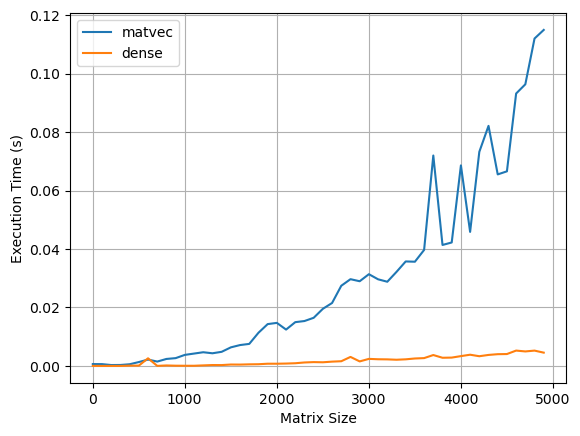

In [13]:
plt.plot(testrange, matvec_times, label='matvec')
plt.plot(testrange, numpy_times, label='dense')
plt.xlabel('Matrix Size')
plt.ylabel('Execution Time (s)')
plt.grid()
plt.legend()

### Discussion
The matvec method shows a significant increase in execution time as the matrix size grows. This is evident from the steep upward trend in the curve. The dense method maintains a consistently low execution time, even as the matrix size increases. The dense implementation appears to be more efficient and scales better with matrix size. The matvec implementation suffers which could be due to less optimal computational efficiency as we are using nested `for` loops even with `jit` compiling.

## Solving matrix problems with `gmres` and `cg`
Here we solve $Ax=B$ to find $x$ where $A$ is some matrix and $B$ is some vector.

* CG: Best suited for symmetric positive definite (SPD) matrices. It leverages the matrix properties to achieve faster convergence. If  $A$ is not SPD, CG may fail or converge poorly.

* GMRES: Does not require $A$ to be SPD, making it applicable to a broader range of matrices. However, GMRES has higher memory requirements because it stores an increasing number of Krylov subspace vectors.

For matrix $A$ to be symmetric, it follows: $$A^T=A$$ and so the element at $[i, j]$ is the same as that at $[j, i]$

In [56]:
n=100
Amatrix = scipy.sparse.random(n, n, format='coo', density=0.3, dtype=np.float64)

# Make the matrix more symmetric and also converts to CSR
Amatrix = Amatrix + Amatrix.T

bvector = np.random.rand(n)

# Call solvers
cg_sol, cg_info = sparse.linalg.cg(Amatrix, bvector)
gmres_sol, gm_info = sparse.linalg.gmres(Amatrix, bvector)

# 0 from info indicates that the solvers converged on a solution
print(cg_info)
print(gm_info)

0
0


In [75]:
assert np.allclose(cg_sol, gmres_sol, rtol=1e-3), "Solutions from CG and GMRES are not sufficiently close."

print("CG and GMRES solutions are effectively the same!")

AssertionError: Solutions from CG and GMRES are not sufficiently close.

### Discussion
To make `CG` solver converge on a solution, we have to make $A$ more symmetric, which is done by adding it's transpose to itself.

The `gmres` solver is a lot slower than `CG` for larger matrices ($150s$ vs $2s$ in this current case).

While both solvers converge and have the same solution to 1.s.f, the solutions from `gmres` and `CG` are not exactly the same because `gmres` is a more complex method that works for any matrix (symmetric or not), whereas `CG` is specifically designed for symmetric positive-definite matrice. Where the matrix is symmetric and positive-definite, the solutions from both methods should be nearly identical, but with other types of matrices, the difference in their convergence rates or stability may cause slight variations in the results.

## Part 2: A custom matrix
Let $A$ be a $2n$ by $2n$ matrix with the structure:
* The top left $n$ by $n$ block is a diagonal matrix. 
* The top right $n$ by $n$ block is zero.
* The bottom left $n$ by $n$ block is zero.
* The bottom right $n$ by $n$ block is dense with a special structure


$$
A = \begin{pmatrix}
* & 0 & 0 & 0 & 0 & 0 \\
0 & * & 0 & 0 & 0 & 0 \\
0 & 0 & * & 0 & 0 & 0 \\
0 & 0 & 0 & * & * & * \\
0 & 0 & 0 & * & * & * \\
0 & 0 & 0 & * & * & * \\
\end{pmatrix}
$$

In [ ]:
class CustomMatrix(LinearOperator):
    def __init__(self, diag, T, W):
        '''
        Generates the custom format matrix

        Inputs
        - diag - Diagonal elements for the top left of the matrix
        - T - Matrix of shape (n, 2)
        - W - Matrix of shape (2, n)

        Outputs
        - 
        '''
        
        # Ensuring appropriate shapes
        assert T.shape == (W.T).shape
        assert diag.shape[0] == T.shape[0]
        assert W.shape[0] == T.shape[1] == 2
        
        # Initialises A properties
        self.shape = (2*diag.shape[0],2*diag.shape[0])
        self.dtype = T.dtype

        self.diag = diag
        self.A_tilde = T @ W
        self.Tarray = T
        self.Warray = W
        
    def _matvec(self, vector):
        '''
        '''
        # Checking dimensions
        assert self.shape[1] == vector.shape[0]
        vector.dtype == self.dtype
        
        # Computing matrix vector product components
        diag_part = self.diag * vector[0:int(len(vector)*0.5)]
        A_tilde_part = np.dot(self.Tarray, np.dot(self.Warray, vector[int(len(vector)*0.5):]))
        
        output = np.append(diag_part,A_tilde_part)
        
        return output

In [ ]:
n=3
diag = np.random.rand(n)
T = np.random.rand(n,2)
W = np.random.rand(2,n)
A = T@W
demomat = CustomMatrix(diag,T,W)

print(demomat.shape)


# Unpacking demomat to display as a dense matrix
densedemo = np.zeros((2*n, 2*n))

for i in range(n):
    densedemo[i][i] = diag[i]

for i in range(n,2*n):
    for j in range(n,2*n):
        densedemo[i][j] = A[i-n][j-n]
        
print(densedemo)

(6, 6)
[[0.04774713 0.         0.         0.         0.         0.        ]
 [0.         0.17740395 0.         0.         0.         0.        ]
 [0.         0.         0.80628393 0.         0.         0.        ]
 [0.         0.         0.         0.78413454 0.62375185 0.05777652]
 [0.         0.         0.         0.67107644 0.54917059 0.45535401]
 [0.         0.         0.         0.78273936 0.62396715 0.09270864]]


In [103]:
testrange = np.arange(100,5001,100)

solve_timessmall = []
solve_timesbig = []

for n in tqdm(testrange):

    # Create matrices
    diag = np.random.rand(n)
    T = np.random.rand(n,2)
    W = np.random.rand(2,n)
    A_corner = T@W

    mat = CustomMatrix(diag,T,W)
    vec = np.random.rand(2*n)
    
    densemat = np.zeros((2*n, 2*n))

    for i in range(n):
        densemat[i][i] = diag[i]

    for i in range(n,2*n):
        for j in range(n,2*n):
            densemat[i][j] = A_corner[i-n][j-n]

    # Timing
    mvt = timeit(lambda:mat @ vec , number=20)
    denset = timeit(lambda:densemat @ vec, number=20)

    solve_timessmall.append(mvt/20)
    solve_timesbig.append(denset/20)

100%|██████████| 50/50 [05:49<00:00,  6.99s/it]


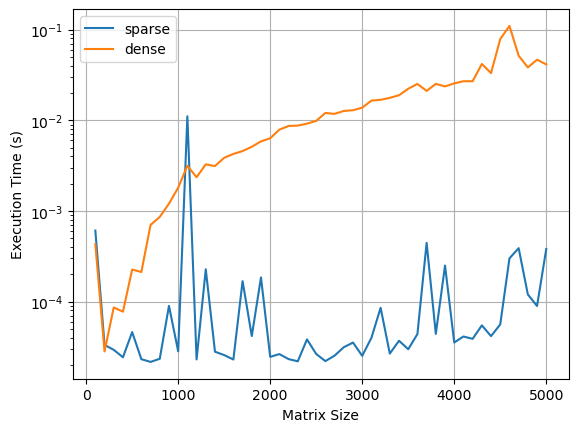

In [107]:
plt.plot(testrange, solve_timessmall, label='sparse')
plt.plot(testrange, solve_timesbig, label='dense')
plt.xlabel('Matrix Size')
plt.ylabel('Execution Time (s)')
plt.yscale('log')
plt.grid()
plt.legend()

### Discussion
We can see the processing time for the "sparse" implementation remains relatively stable as matrix size increases, where instead the dense implementation's time increases exponentially.

The matvec method's execution time remains nearly constant across different matrix sizes, suggesting maybe that matvec scales efficiently with matrix size. The processing time does start to increase towards the end.

The dense method's execution time grows rapidly as the matrix size increases indicating that for larger matrices, the dense approach becomes significantly more computationally expensive. This is expected since dense matrix operations generally have higher computational complexity compared to sparse or specialized matrix operations.